## Objective
To compare the 5RMS threshold crossings detected by the Maxwell software and by my code

In [91]:
%load_ext autoreload
%autoreload

import sys
sys.path.append("/data/MEAprojects/PropSignal")

import numpy as np
import matplotlib.pyplot as plt
from src.get_inputs_from_maxwell import get_inputs_from_maxwell

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
# Paths to files
MY_THRESH_CROSSINGS_PATH = "/data/MEAprojects/PropSignal/data/220705_16460_000443/thresh_crossings_5.npy"
REC_PATH = "/data/MEAprojects/organoid/intrinsic/220705/16460/Network/000443/data.raw.h5"
# Metadata
SAMPLING_FREQ = 20  # in kHz

In [89]:
def count_matching_events(times1, times2, delta=0.4):
    """
    From spikeinterface

    Counts matching events.

    Parameters
    ----------
    times1: list
        List of spike train 1 (in ms)
    times2: list
        List of spike train 2 (in ms)
    delta: int
        ms for considering matching events

    Returns
    -------
    matching_count: int
        Number of matching events
    """
    times_concat = np.concatenate((times1, times2))
    membership = np.concatenate((np.ones(len(times1)) * 1, np.ones(len(times2)) * 2))
    indices = times_concat.argsort()
    times_concat_sorted = times_concat[indices]
    membership_sorted = membership[indices]
    diffs = times_concat_sorted[1:] - times_concat_sorted[:-1]
    inds = np.where((diffs <= delta) & (membership_sorted[:-1] != membership_sorted[1:]))[0]
    if len(inds) == 0:
        return 0
    inds2 = np.where(inds[:-1] + 1 != inds[1:])[0]  # Prevents a spike being matched with more than one other spike
    return len(inds2) + 1

In [5]:
## Get my threshold crossings (st)
st_mine = np.load(MY_THRESH_CROSSINGS_PATH, allow_pickle=True)

In [6]:
## Get Maxwell threshold crossings (st)
st_maxwell, _ = get_inputs_from_maxwell(REC_PATH)

In [99]:
## Compare number of crossings
def count_crossings(crossings):
    return sum(len(c) for c in crossings)

print(f"My crossings: {count_crossings(st_mine)}")
print(f"Mx crossings: {count_crossings(st_maxwell)}")

My crossings: 23634
Mx crossings: 5657


In [100]:
channels = []
for mine, maxwell in zip(st_mine, st_maxwell):
    channels.append(count_matching_events(mine, maxwell))
# mine_to_maxwell = [(channels[i] / len(st_maxwell[i]) if len(st_maxwell[i]) > 0 else np.nan) for i in range(len(channels))]
# print(mine_to_maxwell)
# print([len(st_maxwell[i]) for i in range(len(st_maxwell))])
total_matching = sum(channels)
print(total_matching)
print(f"Matching/Maxwell: {total_matching/count_crossings(st_maxwell)}")
print(f"Matching/Mine: {total_matching/count_crossings(st_mine)}")


4752
Matching/Maxwell: 0.8400212126568852
Matching/Mine: 0.20106626047220105


In [41]:
# np.save("/data/MEAprojects/PropSignal/data/220705_16460_000443/maxwell_st.npy", st_maxwell)

## Plot some threshold crossings

In [9]:
import matplotlib.pyplot as plt
from spikeinterface.extractors import MaxwellRecordingExtractor
from spikeinterface.preprocessing import bandpass_filter, scale
import os
os.environ['HDF5_PLUGIN_PATH'] = '/home/mea/SpikeSorting/spikeinterface/'

In [10]:
# Load recording
FREQ_MIN = 300
FREQ_MAX = 3000
##
recording = MaxwellRecordingExtractor(REC_PATH)
recording = scale(recording, recording.get_channel_gains(), recording.get_channel_offsets())
recording = bandpass_filter(recording, FREQ_MIN, FREQ_MAX)

In [57]:
# Get a thresh crossing that appears in mine but not maxwell
CHAN_IDX = 100
ST = st_mine[CHAN_IDX][0]
##
for st in st_maxwell[CHAN_IDX]:
    if np.isclose(ST, st):
        print("ST found")
        break
else:
    print(f"{ST} not in maxwell")

63934.7 not in maxwell


In [67]:
# Get a thresh crossing that appears in maxwell but not mine
CHAN_IDX = 12
ST = st_maxwell[CHAN_IDX][2]
##
for st in st_mine[CHAN_IDX]:
    if np.isclose(ST, st):
        print("ST found")
        break
else:
    print(f"{ST} not in mine")

581156.0 not in mine


1.7791381



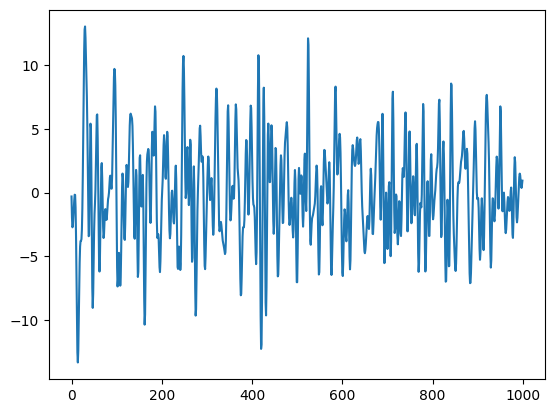

1.2451613



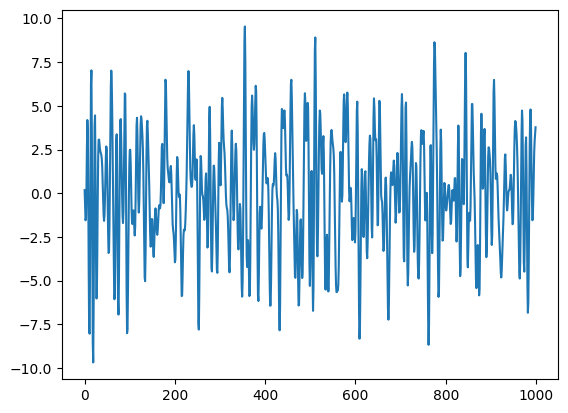

0.8750978



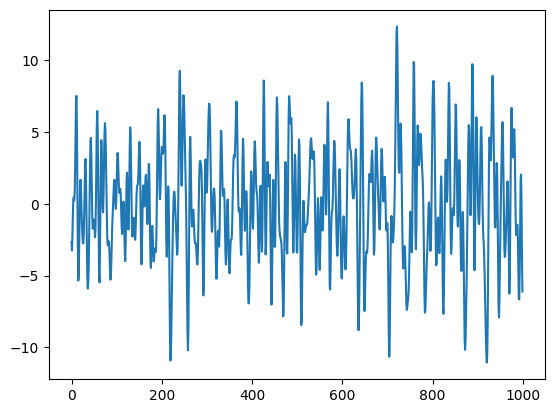

3.2657218



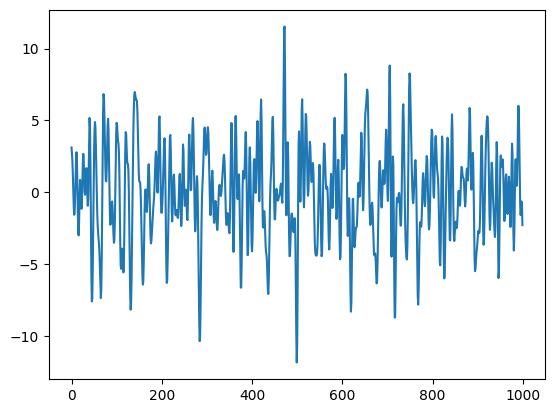

In [111]:
#
CHAN_IDX = 32
HALF_WINDOW_SIZE = 500
## Plot ST
for st in st_maxwell[CHAN_IDX]:
    broken = False
    for st2 in st_mine[CHAN_IDX]:
        if np.abs(st - st2) <= 0.4:
            broken = True
            break
    if broken: continue

    if st in st_mine[CHAN_IDX]: continue
    st = int(st * SAMPLING_FREQ)  # ms to frames
    trace = recording.get_traces(start_frame=st-HALF_WINDOW_SIZE, end_frame=st+HALF_WINDOW_SIZE,
                                 channel_ids=[recording.get_channel_ids()[CHAN_IDX]]).flatten()
    print(np.abs(trace[HALF_WINDOW_SIZE]) / np.sqrt(np.mean(np.square(trace))))
    print()
    plt.plot(trace)
    plt.show()

In [44]:
len(st_mine)

198

In [75]:
for chan in st_mine:
    for st in chan:
        if not isinstance(st, np.float64):
            print(type(st))